### 1. SETUP

In [7]:
print("Memulai Bagian 1: Setup...")

# Impor library umum
import sys
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

# Konfigurasi versi (memastikan environment sesuai)
assert sys.version_info >= (3, 5)
assert tf.__version__ >= "2.0"
assert sklearn.__version__ >= "0.20"

# Atur seed untuk reproduktifitas
np.random.seed(42)
tf.random.set_seed(42)

# Konfigurasi plot Matplotlib
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Fungsi bantuan untuk menampilkan gambar
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Fungsi bantuan untuk menampilkan rekonstruksi gambar
def show_reconstructions(model, images, n_images=5):
    # Lakukan prediksi pada beberapa gambar
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Tampilkan gambar asli
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        # Tampilkan gambar hasil rekonstruksi
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    # Tampilkan plot
    plt.show()

# Fungsi bantuan untuk plot beberapa gambar dalam grid
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    # Tampilkan plot
    plt.show()

print("Setup selesai.")

Memulai Bagian 1: Setup...
Setup selesai.


### 2. PCA DENGAN LINEAR AUTOENCODER

Melatih autoencoder linear...


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pelatihan selesai.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


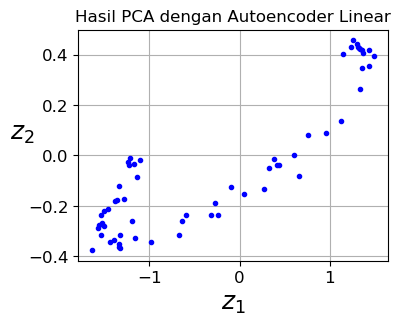

In [8]:
# Membuat dataset 3D sintetis
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train_pca = generate_3d_data(60)
X_train_pca = X_train_pca - X_train_pca.mean(axis=0, keepdims=0)

# Membangun model Autoencoder linear sederhana
# Encoder: 3D -> 2D
encoder_pca = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
# Decoder: 2D -> 3D
decoder_pca = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder_pca = keras.models.Sequential([encoder_pca, decoder_pca])

# Meng-compile model
autoencoder_pca.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

# Melatih model
print("Melatih autoencoder linear...")
history = autoencoder_pca.fit(X_train_pca, X_train_pca, epochs=4, verbose=0)
print("Pelatihan selesai.")

# Memprediksi (meng-encode) data training untuk mendapatkan representasi 2D (codings)
codings = encoder_pca.predict(X_train_pca)

# Menampilkan hasil 'codings' yang merupakan proyeksi data ke 2D
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.title("Hasil PCA dengan Autoencoder Linear")
plt.show()

### 3. STACKED AUTOENCODERS


Memulai Bagian 3: Stacked Autoencoders...
--- 3.1 Melatih Stacked Autoencoder sekaligus ---
Melatih stacked autoencoder...
Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.3817 - rounded_accuracy: 0.8498 - val_loss: 0.3170 - val_rounded_accuracy: 0.9010
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3080 - rounded_accuracy: 0.9129 - val_loss: 0.3050 - val_rounded_accuracy: 0.9146
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3003 - rounded_accuracy: 0.9197 - val_loss: 0.3061 - val_rounded_accuracy: 0.9074
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.2953 - rounded_accuracy: 0.9241 - val_loss: 0.2984 - val_rounded_accuracy: 0.9183
Menampilkan rekonstruksi dari stacked autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


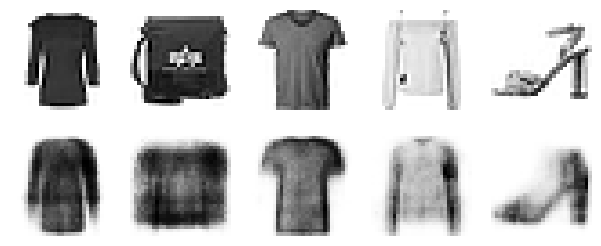


--- 3.2 Visualisasi data terkompresi dengan t-SNE ---
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


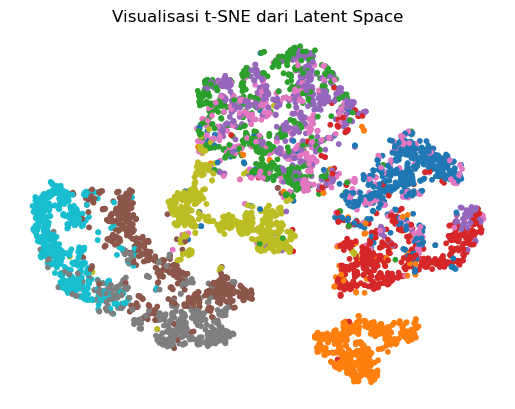

In [9]:
print("\nMemulai Bagian 3: Stacked Autoencoders...")

# Memuat dataset Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Metrik kustom untuk akurasi biner yang dibulatkan
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# --- 3.1 Melatih semua layer sekaligus ---
print("--- 3.1 Melatih Stacked Autoencoder sekaligus ---")
tf.random.set_seed(42)
np.random.seed(42)

# Definisikan arsitektur stacked autoencoder
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5),
                   metrics=[rounded_accuracy])

print("Melatih stacked autoencoder...")
# Mengurangi epoch dari 20 menjadi 10 untuk kecepatan
history = stacked_ae.fit(X_train, X_train, epochs=4,
                         validation_data=(X_valid, X_valid))

# Menampilkan hasil rekonstruksi
print("Menampilkan rekonstruksi dari stacked autoencoder:")
show_reconstructions(stacked_ae, X_valid)

# --- 3.2 Visualisasi Fashion MNIST dengan t-SNE ---
print("\n--- 3.2 Visualisasi data terkompresi dengan t-SNE ---")
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(n_components=2, random_state=42) # n_components=2 untuk visualisasi 2D
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# Plot scatter sederhana
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.title("Visualisasi t-SNE dari Latent Space")
plt.show()


--- 3.3 Stacked Autoencoder dengan Tying Weights ---
Melatih autoencoder dengan tied weights...
Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.3719 - rounded_accuracy: 0.8567 - val_loss: 0.3075 - val_rounded_accuracy: 0.9074
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2992 - rounded_accuracy: 0.9203 - val_loss: 0.2977 - val_rounded_accuracy: 0.9176
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.2923 - rounded_accuracy: 0.9266 - val_loss: 0.2915 - val_rounded_accuracy: 0.9266
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.2888 - rounded_accuracy: 0.9297 - val_loss: 0.2894 - val_rounded_accuracy: 0.9284
Menampilkan rekonstruksi dari tied autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


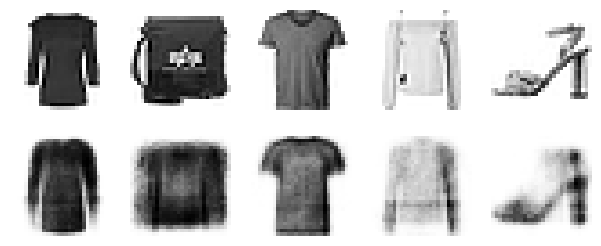

In [11]:
# --- 3.3 Tying Weights ---
print("\n--- 3.3 Stacked Autoencoder dengan Tying Weights ---")
# Tying weights berarti decoder menggunakan transpose dari weight encoder.
# Ini mengurangi jumlah parameter dan dapat mempercepat konvergensi.
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            name="bias",
            shape=[self.dense.kernel.shape[0]],
            initializer="zeros"
        )
        super().build(batch_input_shape)


    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.kernel, transpose_b=True)
        return self.activation(z + self.biases)

# Membersihkan sesi Keras sebelumnya
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Definisikan layer dense yang akan di-share
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

# Encoder dengan layer yang sudah didefinisikan
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

# Decoder menggunakan layer kustom DenseTranspose
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5),
                metrics=[rounded_accuracy])

print("Melatih autoencoder dengan tied weights...")
history = tied_ae.fit(X_train, X_train, epochs=4,
                      validation_data=(X_valid, X_valid))

print("Menampilkan rekonstruksi dari tied autoencoder:")
show_reconstructions(tied_ae, X_valid)

### 4. CONVOLUTIONAL AUTOENCODERS


Memulai Bagian 4: Convolutional Autoencoders...
Melatih convolutional autoencoder...


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/4


2025-06-20 23:02:44.441124: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,16,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:02:44.522412: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,14,14]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

1713/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3337 - rounded_accuracy: 0.8924

2025-06-20 23:03:03.371594: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,16,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,1,28,28]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:03:03.420913: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,16,14,14]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3336 - rounded_accuracy: 0.8925

2025-06-20 23:03:06.571173: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,14,14]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:03:06.650521: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,7,7]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.3335 - rounded_accuracy: 0.8925 - val_loss: 0.2803 - val_rounded_accuracy: 0.9381
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2762 - rounded_accuracy: 0.9405 - val_loss: 0.2761 - val_rounded_accuracy: 0.9402
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.2710 - rounded_accuracy: 0.9459 - val_loss: 0.2710 - val_rounded_accuracy: 0.9467
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.2681 - rounded_accuracy: 0.9489 - val_loss: 0.2676 - val_rounded_accuracy: 0.9512
Ringkasan model Conv Encoder:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,296 (91.00 KB)

 Trainable params: 23,296 (91.00 KB)

 Non-trainable params: 0 (0.00 B)


Ringkasan model Conv Decoder:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 7, 7, 32)       │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           145 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,233 (90.75 KB)

 Trainable params: 23,233 (90.75 KB)

 Non-trainable params: 0 (0.00 B)


Menampilkan rekonstruksi dari convolutional autoencoder:


2025-06-20 23:03:53.282486: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,16,14,14]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:03:53.373983: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,64,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,7,7]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


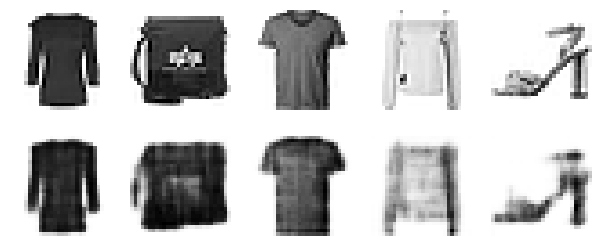

In [12]:
print("\nMemulai Bagian 4: Convolutional Autoencoders...")
# Menggunakan layer konvolusi lebih cocok untuk data gambar.

tf.random.set_seed(42)
np.random.seed(42)

# Definisikan encoder dengan layer Conv2D dan MaxPool2D
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

# Definisikan decoder dengan layer Conv2DTranspose (deconvolution)
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])

print("Melatih convolutional autoencoder...")
# Menggunakan 5 epoch untuk demonstrasi cepat
history = conv_ae.fit(X_train, X_train, epochs=4,
                      validation_data=(X_valid, X_valid))

print("Ringkasan model Conv Encoder:")
conv_encoder.summary()
print("\nRingkasan model Conv Decoder:")
conv_decoder.summary()

print("\nMenampilkan rekonstruksi dari convolutional autoencoder:")
show_reconstructions(conv_ae, X_valid)

### 5. RECURRENT AUTOENCODERS


Memulai Bagian 5: Recurrent Autoencoders...


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/repeat_vector.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Melatih recurrent autoencoder...
Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - loss: 0.5569 - rounded_accuracy: 0.7141 - val_loss: 0.4459 - val_rounded_accuracy: 0.8141
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - loss: 0.4198 - rounded_accuracy: 0.8306 - val_loss: 0.3757 - val_rounded_accuracy: 0.8660
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - loss: 0.3688 - rounded_accuracy: 0.8690 - val_loss: 0.3569 - val_rounded_accuracy: 0.8793
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - loss: 0.3528 - rounded_accuracy: 0.8803 - val_loss: 0.3484 - val_rounded_accuracy: 0.8821

Menampilkan rekonstruksi dari recurrent autoencoder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


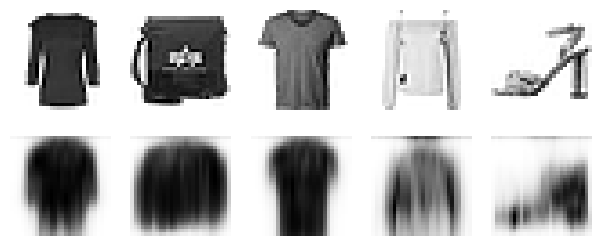

In [13]:
print("\nMemulai Bagian 5: Recurrent Autoencoders...")
# Menggunakan layer LSTM untuk memproses gambar sebagai sekuens (baris per baris).

tf.random.set_seed(42)
np.random.seed(42)

# Encoder dengan layer LSTM
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

# Decoder menggunakan RepeatVector untuk mengulang output encoder, lalu LSTM
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1),
                     metrics=[rounded_accuracy])

print("Melatih recurrent autoencoder...")
# Mengurangi epoch dari 10 menjadi 5
history = recurrent_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

print("\nMenampilkan rekonstruksi dari recurrent autoencoder:")
show_reconstructions(recurrent_ae, X_valid)

### 6. DENOISING AUTOENCODERS


Memulai Bagian 6: Denoising Autoencoders...
--- 6.1 Denoising AE dengan Gaussian Noise ---
Melatih denoising autoencoder (Gaussian)...


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.3951 - rounded_accuracy: 0.8385 - val_loss: 0.3201 - val_rounded_accuracy: 0.8998
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.3136 - rounded_accuracy: 0.9081 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3058 - rounded_accuracy: 0.9147 - val_loss: 0.3020 - val_rounded_accuracy: 0.9217
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3011 - rounded_accuracy: 0.9189 - val_loss: 0.2988 - val_rounded_accuracy: 0.9218

Menampilkan rekonstruksi dari input yang diberi noise (Gaussian):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


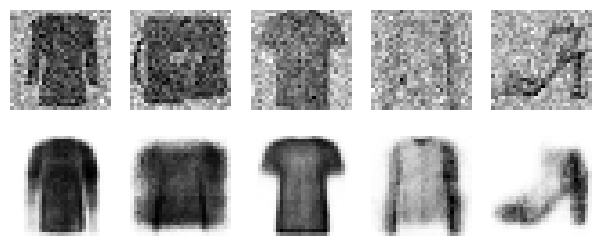


--- 6.2 Denoising AE dengan Dropout ---
Melatih denoising autoencoder (Dropout)...
Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.4017 - rounded_accuracy: 0.8301 - val_loss: 0.3214 - val_rounded_accuracy: 0.8989
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3195 - rounded_accuracy: 0.9017 - val_loss: 0.3115 - val_rounded_accuracy: 0.9119
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3125 - rounded_accuracy: 0.9073 - val_loss: 0.3071 - val_rounded_accuracy: 0.9139
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.3083 - rounded_accuracy: 0.9107 - val_loss: 0.3028 - val_rounded_accuracy: 0.9177

Menampilkan rekonstruksi dari input yang diberi noise (Dropout):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


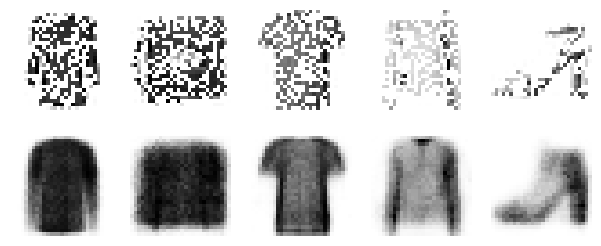

In [14]:
print("\nMemulai Bagian 6: Denoising Autoencoders...")
# Melatih autoencoder untuk merekonstruksi gambar bersih dari input yang diberi noise.

tf.random.set_seed(42)
np.random.seed(42)

# --- 6.1 Menggunakan Gaussian Noise ---
print("--- 6.1 Denoising AE dengan Gaussian Noise ---")
# Encoder dengan layer GaussianNoise
denoising_encoder_gauss = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder_gauss = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae_gauss = keras.models.Sequential([denoising_encoder_gauss, denoising_decoder_gauss])
denoising_ae_gauss.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])

print("Melatih denoising autoencoder (Gaussian)...")
history = denoising_ae_gauss.fit(X_train, X_train, epochs=4,
                           validation_data=(X_valid, X_valid))

# Tampilkan rekonstruksi dari gambar yang diberi noise
print("\nMenampilkan rekonstruksi dari input yang diberi noise (Gaussian):")
noise_layer = keras.layers.GaussianNoise(0.2)
X_valid_noisy_gauss = noise_layer(X_valid, training=True)
show_reconstructions(denoising_ae_gauss, X_valid_noisy_gauss)

# --- 6.2 Menggunakan Dropout ---
print("\n--- 6.2 Denoising AE dengan Dropout ---")
# Encoder dengan layer Dropout
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])

print("Melatih denoising autoencoder (Dropout)...")
history = dropout_ae.fit(X_train, X_train, epochs=4,
                         validation_data=(X_valid, X_valid))

# Tampilkan rekonstruksi dari gambar yang diberi noise (dropout)
print("\nMenampilkan rekonstruksi dari input yang diberi noise (Dropout):")
dropout_layer = keras.layers.Dropout(0.5)
X_valid_noisy_dropout = dropout_layer(X_valid, training=True)
show_reconstructions(dropout_ae, X_valid_noisy_dropout)

### 7. SPARSE AUTOENCODERS


Memulai Bagian 7: Sparse Autoencoders...
--- 7.1 Sparse AE dengan L1 Regularization ---
Melatih sparse autoencoder (L1)...
Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.6179 - rounded_accuracy: 0.7130 - val_loss: 0.4934 - val_rounded_accuracy: 0.7289
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.4902 - rounded_accuracy: 0.7317 - val_loss: 0.4929 - val_rounded_accuracy: 0.7289
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4899 - rounded_accuracy: 0.7317 - val_loss: 0.4928 - val_rounded_accuracy: 0.7289
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4898 - rounded_accuracy: 0.7317 - val_loss: 0.4927 - val_rounded_accuracy: 0.7289

Menampilkan rekonstruksi dari sparse autoencoder (L1):
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


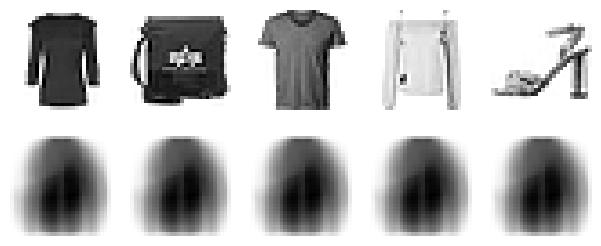


--- 7.2 Sparse AE dengan KL Divergence ---
Melatih sparse autoencoder (KL Divergence)...
Epoch 1/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.7189 - rounded_accuracy: 0.7363 - val_loss: 0.4719 - val_rounded_accuracy: 0.8021
Epoch 2/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4052 - rounded_accuracy: 0.8355 - val_loss: 0.4234 - val_rounded_accuracy: 0.8234
Epoch 3/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3857 - rounded_accuracy: 0.8554 - val_loss: 0.4017 - val_rounded_accuracy: 0.8379
Epoch 4/4
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.3676 - rounded_accuracy: 0.8749 - val_loss: 0.3935 - val_rounded_accuracy: 0.8363

Menampilkan rekonstruksi dari sparse autoencoder (KL):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


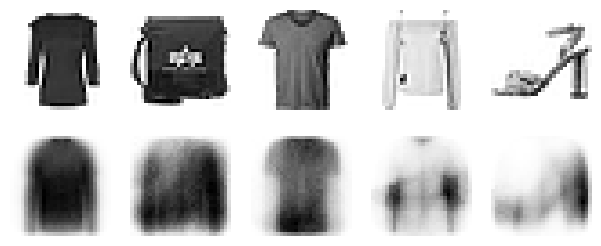

In [15]:
print("\nMemulai Bagian 7: Sparse Autoencoders...")
# Mendorong agar neuron di lapisan pengkodean (coding layer) tidak aktif (bernilai nol).
# Ini memaksa model untuk belajar fitur yang lebih berguna.

# --- 7.1 Menggunakan L1 Regularization ---
print("--- 7.1 Sparse AE dengan L1 Regularization ---")
tf.random.set_seed(42)
np.random.seed(42)

# Menambahkan ActivityRegularization dengan L1
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"), # Meningkatkan jumlah neuron untuk sparsity
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])

print("Melatih sparse autoencoder (L1)...")
history = sparse_l1_ae.fit(X_train, X_train, epochs=4,
                           validation_data=(X_valid, X_valid))

print("\nMenampilkan rekonstruksi dari sparse autoencoder (L1):")
show_reconstructions(sparse_l1_ae, X_valid)

# --- 7.2 Menggunakan KL Divergence Regularizer ---
print("\n--- 7.2 Sparse AE dengan KL Divergence ---")
# Regularizer kustom untuk mendorong sparsity menuju target tertentu (misal, 10% aktivasi)
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            keras.losses.kullback_leibler_divergence(self.target, mean_activities) +
            keras.losses.kullback_leibler_divergence(1. - self.target, 1. - mean_activities))

tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])

print("Melatih sparse autoencoder (KL Divergence)...")
history = sparse_kl_ae.fit(X_train, X_train, epochs=4,
                           validation_data=(X_valid, X_valid))

print("\nMenampilkan rekonstruksi dari sparse autoencoder (KL):")
show_reconstructions(sparse_kl_ae, X_valid)

### 8. VARIATIONAL AUTOENCODER (VAE)


Memulai Bagian 8: Variational Autoencoder (VAE)...
Melatih VAE...
Epoch 1/4
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.4721 - rounded_accuracy: 0.7814 - val_loss: 0.3619 - val_rounded_accuracy: 0.8899
Epoch 2/4
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3586 - rounded_accuracy: 0.8868 - val_loss: 0.3481 - val_rounded_accuracy: 0.8983
Epoch 3/4
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3472 - rounded_accuracy: 0.8942 - val_loss: 0.3429 - val_rounded_accuracy: 0.9021
Epoch 4/4
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3399 - rounded_accuracy: 0.8999 - val_loss: 0.3379 - val_rounded_accuracy: 0.9026

Menampilkan rekonstruksi dari VAE:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


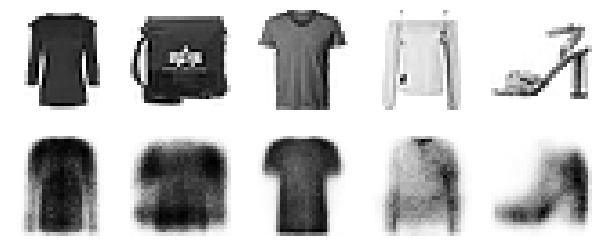


Menghasilkan gambar fashion baru dari VAE...


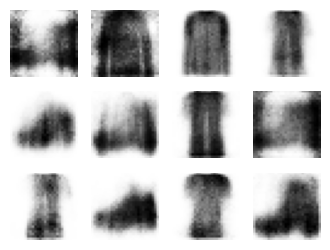

In [20]:
print("\nMemulai Bagian 8: Variational Autoencoder (VAE)...")

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

class KLDivergenceLayer(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mean) - tf.exp(log_var),
            axis=1
        )
        self.add_loss(tf.reduce_mean(kl_loss) / 784.0)
        return mean, log_var

# Setup
tf.random.set_seed(42)
np.random.seed(42)
codings_size = 10

# --- ENCODER ---
inputs = keras.layers.Input(shape=[28, 28])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(100, activation="selu")(x)
z_mean = keras.layers.Dense(codings_size)(x)
z_log_var = keras.layers.Dense(codings_size)(x)

# Tambahkan KL loss di sini
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, z, name="encoder")

# --- DECODER ---
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
decoder = keras.Model(decoder_inputs, outputs, name="decoder")

# --- VAE ---
vae_outputs = decoder(encoder(inputs))
vae = keras.Model(inputs, vae_outputs, name="vae")

# Compile
vae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

# Train
print("Melatih VAE...")
vae.fit(X_train, X_train, epochs=4, batch_size=128, validation_data=(X_valid, X_valid))

# Rekonstruksi
print("\nMenampilkan rekonstruksi dari VAE:")
show_reconstructions(vae, X_valid)

# Sampling dan generate gambar
print("\nMenghasilkan gambar fashion baru dari VAE...")
codings = tf.random.normal(shape=[12, codings_size])
images = decoder(codings).numpy()
plot_multiple_images(images, 4)

### 9. GENERATIVE ADVERSARIAL NETWORKS (GAN)


Memulai Bagian 9: Generative Adversarial Networks (GAN)...
Melatih GAN...
Epoch 1/4


2025-06-20 23:12:44.864712: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Hasil generator pada akhir epoch:


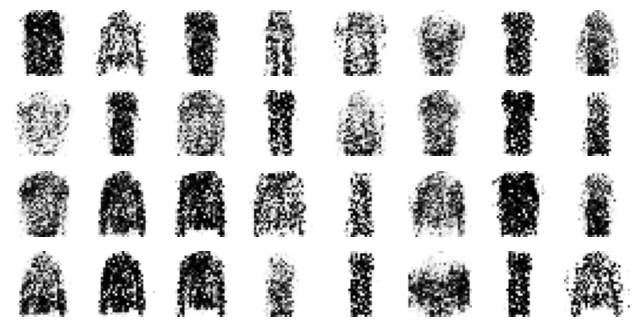

Epoch 2/4
Hasil generator pada akhir epoch:


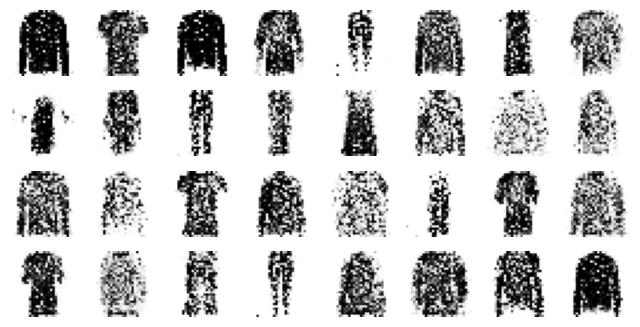

Epoch 3/4


2025-06-20 23:14:01.947430: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Hasil generator pada akhir epoch:


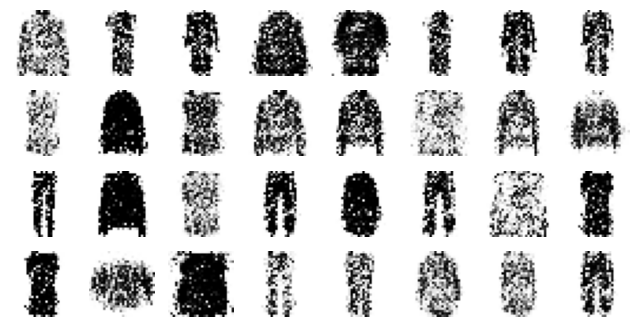

Epoch 4/4
Hasil generator pada akhir epoch:


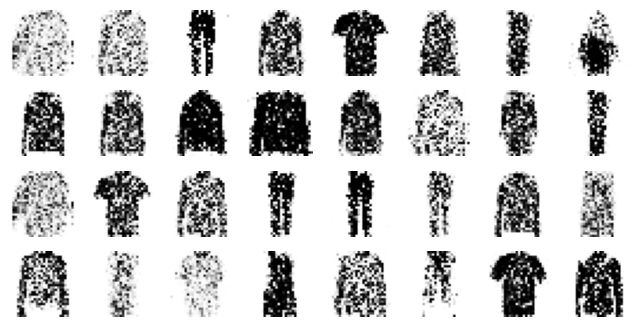

In [17]:
print("\nMemulai Bagian 9: Generative Adversarial Networks (GAN)...")
# GAN terdiri dari Generator (pemalsu) dan Discriminator (polisi)
# yang dilatih secara bersamaan dalam sebuah permainan.

np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

# Generator: membuat gambar dari noise acak
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
# Discriminator: membedakan gambar asli dan palsu
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
# Model GAN: menggabungkan generator dan discriminator
gan = keras.models.Sequential([generator, discriminator])

# Compile discriminator
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # Penting: freeze discriminator saat melatih generator

# Compile model GAN
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Menyiapkan dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Loop pelatihan kustom untuk GAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=4):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # Fase 1: Melatih discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # 0 untuk palsu, 1 untuk asli
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # Fase 2: Melatih generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # Ingin menipu discriminator agar mengira palsu itu asli
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        # Tampilkan hasil generator setiap epoch
        print("Hasil generator pada akhir epoch:")
        plot_multiple_images(generated_images.numpy(), 8)

# Melatih GAN, mengurangi epoch dari 50 menjadi 5
print("Melatih GAN...")
train_gan(gan, dataset, batch_size, codings_size, n_epochs=4)

### 10. DEEP CONVOLUTIONAL GAN (DCGAN)


Memulai Bagian 10: Deep Convolutional GAN (DCGAN)...


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Melatih DCGAN...
Epoch 1/4
Hasil generator pada akhir epoch:


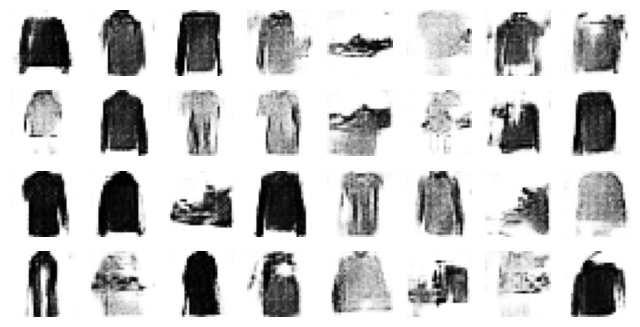

Epoch 2/4
Hasil generator pada akhir epoch:


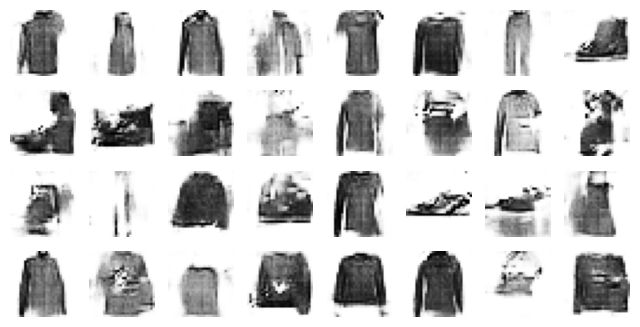

Epoch 3/4


2025-06-20 23:17:53.096386: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Hasil generator pada akhir epoch:


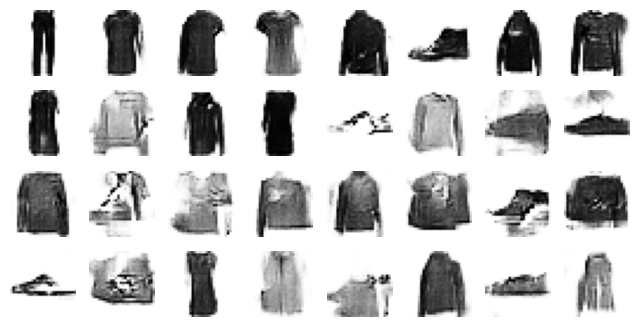

Epoch 4/4
Hasil generator pada akhir epoch:


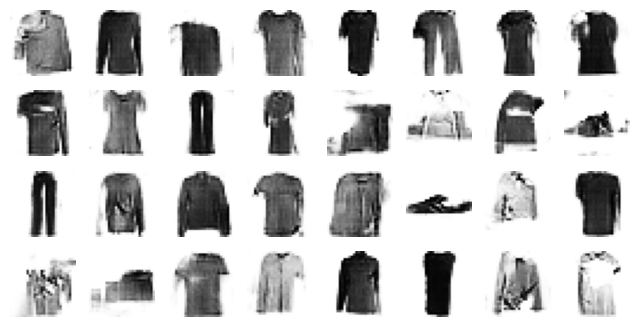

In [18]:
print("\nMemulai Bagian 10: Deep Convolutional GAN (DCGAN)...")
# DCGAN adalah arsitektur GAN yang menggunakan layer konvolusional,
# yang lebih stabil dan menghasilkan gambar yang lebih baik.

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

# Generator DCGAN
generator_dcgan = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh"),
])

# Discriminator DCGAN
discriminator_dcgan = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan_dcgan = keras.models.Sequential([generator_dcgan, discriminator_dcgan])

# Compile discriminator dan GAN
discriminator_dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator_dcgan.trainable = False
gan_dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Menyiapkan data: reshape dan rescale ke rentang [-1, 1] (karena generator menggunakan 'tanh')
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

# Menyiapkan dataset
batch_size_dcgan = 32
dataset_dcgan = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset_dcgan = dataset_dcgan.shuffle(1000)
dataset_dcgan = dataset_dcgan.batch(batch_size_dcgan, drop_remainder=True).prefetch(1)

# Melatih DCGAN
print("Melatih DCGAN...")
# Mengurangi epoch dari 50 menjadi 10
train_gan(gan_dcgan, dataset_dcgan, batch_size_dcgan, codings_size, n_epochs=4)

---
##  Ringkasan Arsitektur dan Hasil
---
###  GAN Sederhana (Berbasis Dense Layer)
- **Generator**: Beberapa lapisan `Dense` yang mengubah vektor noise acak menjadi gambar 28x28.
- **Diskriminator**: Lapisan `Dense` yang mengklasifikasikan gambar sebagai nyata atau palsu.
- **Training**: Dilatih dalam loop adversarial minimax.
- **Hasil**: Gambar masih sangat buram dan noisy, tetapi bentuk dasar item fesyen mulai muncul.

###  DCGAN (Deep Convolutional GAN)
- **Generator**: Menggunakan `Conv2DTranspose` untuk upsampling.
- **Diskriminator**: Menggunakan `Conv2D` untuk ekstraksi fitur.
- **Fitur Tambahan**: BatchNormalization untuk stabilisasi training.
- **Hasil**: Gambar jauh lebih tajam dan detail; item pakaian lebih mudah dikenali seperti sepatu dan gaun.

###  ProGAN (Konsep)
- **Metode**: Mulai dari gambar kecil (mis. 4x4), kemudian secara progresif menambahkan lapisan untuk meningkatkan resolusi.
- **Keuntungan**: Pelatihan lebih stabil, hasil berkualitas tinggi.
- **Catatan**: Tidak diimplementasikan dalam kode, hanya dijelaskan sebagai konsep.

###  StyleGAN (Konsep)
- **Inovasi**:
  - `Mapping Network` (z → w): Kontrol fitur lebih baik.
  - `AdaIN`: Suntikkan gaya ke tiap lapisan generator.
  - `Input Noise`: Tambahan noise stokastik untuk detail realistis (seperti tekstur kulit).
- **Hasil**: Teoritis, menghasilkan gambar realistis dengan kontrol gaya tinggi.
- **Catatan**: Konsep dijelaskan, tidak diimplementasikan secara langsung.

---

##  Tabel Perbandingan

| Arsitektur     | Komponen Utama                          | Kualitas Gambar            | Keterangan                                                  |
|----------------|------------------------------------------|-----------------------------|-------------------------------------------------------------|
| GAN Sederhana  | Dense Layers                             | Sangat buram & berisik      | Cocok untuk pemahaman awal konsep adversarial              |
| DCGAN          | Conv2D & Conv2DTranspose + BatchNorm     | Tajam & dapat dikenali      | Menunjukkan pentingnya konvolusi dalam generasi gambar     |
| ProGAN         | Progressive Growing (Konsep)             | Resolusi tinggi (teoritis)  | Teknik efektif untuk pelatihan GAN gambar besar            |
| StyleGAN       | Mapping Network, AdaIN, Input Noise      | Sangat realistis (teoritis) | Standar industri untuk generasi gambar bergaya dan presisi |

---

##  Kesimpulan Akhir

- Transisi dari **GAN Sederhana** ke **DCGAN** membuktikan bahwa desain arsitektur berdampak signifikan terhadap kualitas hasil.
- Konsep **ProGAN** dan **StyleGAN** memperlihatkan bahwa GAN modern mampu mengatasi tantangan training dan menghasilkan gambar yang sangat realistis.
- Meskipun tidak semuanya diimplementasikan, pemahaman konsep lanjutan ini membuka wawasan penting terhadap riset dan aplikasi GAN masa kini.